# **Klasifikasi Curah Hujan Berbasis Machine Learning pada Data Cuaca Australia**


Data set : https://www.kaggle.com/datasets/arunavakrchakraborty/australia-weather-data?resource




Cuaca, dan kemampuan manusia untuk memprediksinya secara akurat, memainkan peran penting dalam banyak aspek kehidupan. Mulai dari petani yang menanam tanaman, keluarga yang merencanakan liburan akhir pekan, hingga pengambilan keputusan logistik dalam maskapai penerbangan, hujan khususnya memiliki pengaruh besar terhadap rencana.

Dalam beberapa kasus, dampak hujan dapat menimbulkan konsekuensi finansial yang signifikan. Oleh karena itu, terdapat minat yang besar dari berbagai pemangku kepentingan terhadap kemampuan untuk memprediksi hujan secara akurat. Tujuan dari proyek ini adalah menggunakan data yang tersedia untuk membuat model prediksi apakah akan hujan pada hari berikutnya. Model semacam ini dapat dimanfaatkan dalam aplikasi cuaca untuk kepentingan masyarakat luas.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, when, rand, mean
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

sns.set_style('darkgrid')

In [ ]:
spark = SparkSession.builder.appName("weather_classification").getOrCreate()
spark.sparkContext.setLogLevel("ERROR") # Suppressing Warnings, allowing only Errors
spark

In [ ]:
df = spark.read.format("csv").option("header","true").option("inferSchema", "true").load("/content/Weather Training Data.csv")
df.show(5)

+------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|row ID|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|  Row0|  Albury|   13.4|   22.9|     0.6|       NULL|    NULL|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|    NULL|   16.9|   21.8|       No|           0|
|  Row1|  Albury|    7.4|   

In [ ]:
print("Number of columns: ",len(df.columns))
print("Number of rows: ",df.count())

Number of columns:  23
Number of rows:  99516


In [ ]:
display (df.printSchema())


root
 |-- row ID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- Evaporation: double (nullable = true)
 |-- Sunshine: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: integer (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: integer (nullable = true)
 |-- WindSpeed3pm: integer (nullable = true)
 |-- Humidity9am: integer (nullable = true)
 |-- Humidity3pm: integer (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- Cloud9am: integer (nullable = true)
 |-- Cloud3pm: integer (nullable = true)
 |-- Temp9am: double (nullable = true)
 |-- Temp3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: integer (nullable = true)



None

In [ ]:
df_summary_transposed = df.limit(5).toPandas().transpose()
df_summary_transposed

,0,1,2,3,4
row ID,Row0,Row1,Row2,Row3,Row4
Location,Albury,Albury,Albury,Albury,Albury
MinTemp,13.4,7.4,17.5,14.6,7.7
MaxTemp,22.9,25.1,32.3,29.7,26.7
Rainfall,0.6,0.0,1.0,0.2,0.0
Evaporation,NaN,NaN,NaN,NaN,NaN
Sunshine,NaN,NaN,NaN,NaN,NaN
WindGustDir,W,WNW,W,WNW,W
WindGustSpeed,44,44,41,56,35
WindDir9am,W,NNW,ENE,W,SSE


## **Data Cleansing**

In [ ]:
df = df.drop('row ID')

In [ ]:
# Calculate the number of null values in each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Calculate the total number of rows
total_rows = df.count()

# Calculate the percentage of null values in each column
null_percentages = null_counts.toPandas().transpose() / total_rows * 100

# Create a table that shows the total number of occurrences, the number of null variables, and the percentage between them
null_table = null_counts.toPandas().transpose()
null_table["Total Occurrences"] = total_rows
null_table.columns = ["Number of Null Values", "Total Occurrences"]
null_table["Percentage of Null Values"] = null_percentages.round(2)

null_table = null_table[["Total Occurrences", "Number of Null Values", "Percentage of Null Values"]]

null_table
#Only for numerical values


,Total Occurrences,Number of Null Values,Percentage of Null Values
Location,99516,0,0.00
MinTemp,99516,443,0.45
MaxTemp,99516,230,0.23
Rainfall,99516,979,0.98
Evaporation,99516,42531,42.74
Sunshine,99516,47317,47.55
WindGustDir,99516,0,0.00
WindGustSpeed,99516,6480,6.51
WindDir9am,99516,0,0.00
WindDir3pm,99516,0,0.00


In [ ]:
num_cols = [c for c, dtype in df.dtypes if dtype in ["double", "int","float"]]
mean_values = df.select([mean(c).alias(c) for c in num_cols]).first().asDict() # Calculate mean of each column
for col_name in num_cols:
    df = df.fillna(mean_values[col_name], subset=[col_name]) # Fill the null values with mean

In [ ]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]) # Calculate null values in each column
null_counts.show()

+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|       0|      0|      0|       0|          0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|       0|       0|      0|      0|        0|           0|
+--------+-------+-------+--------+-----------+--------+

In [ ]:
summary = df.select(num_cols).describe()
summary.show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------+------------------+-----------------+-----------------+------------------+-------------------+
|summary|           MinTemp|           MaxTemp|          Rainfall|       Evaporation|         Sunshine|     WindGustSpeed|      WindSpeed9am|      WindSpeed3pm|       Humidity9am|       Humidity3pm|       Pressure9am|     Pressure3pm|          Cloud9am|         Cloud3pm|          Temp9am|           Temp3pm|       RainTomorrow|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------+------------------+-----------------+-----------------+------------------+-------------------+
|  count|    

In [ ]:
non_numeric_cols = [c for c, dtype in df.dtypes if dtype not in ["double", "int","float"]]

for col_name in non_numeric_cols:
    df.groupBy(col(col_name)).count().show() # Display the distribution of values for each non-numerical column

+----------------+-----+
|        Location|count|
+----------------+-----+
|          Cairns| 2101|
|   NorfolkIsland| 2038|
|         Bendigo| 2110|
|        Canberra| 2393|
|        Adelaide| 2178|
|           Cobar| 2090|
|   SydneyAirport| 2100|
|      Wollongong| 2090|
|     Williamtown| 1816|
|           Moree| 2020|
|         Mildura| 2124|
|        Portland| 2113|
|        Brisbane| 2202|
|          Sydney| 2361|
|            Sale| 2093|
|   BadgerysCreek| 2041|
|     Tuggeranong| 2099|
|        Ballarat| 2122|
|       GoldCoast| 2057|
|MelbourneAirport| 2139|
+----------------+-----+
only showing top 20 rows
+-----------+-----+
|WindGustDir|count|
+-----------+-----+
|        SSE| 6329|
|         SW| 6233|
|         NW| 5599|
|         NA| 6521|
|          E| 6341|
|        WSW| 6164|
|        ENE| 5558|
|         NE| 4956|
|        NNW| 4589|
|          N| 6323|
|        SSW| 6023|
|          W| 6843|
|          S| 6228|
|         SE| 6475|
|        WNW| 5664|
|        NNE| 4

In [ ]:
for col_name in non_numeric_cols:
    count_df = df.filter(col(col_name) == "NA").agg(count("*").alias("count")) # Calculate NA occurances
    total_count = df.count()
    proportion = count_df.collect()[0]["count"] / total_count * 100 # Calculate the proportion
    print("Proportion of Empty Values in column '{}': {:.2f}%".format(col_name, proportion))

Proportion of Empty Values in column 'Location': 0.00%
Proportion of Empty Values in column 'WindGustDir': 6.55%
Proportion of Empty Values in column 'WindDir9am': 7.04%
Proportion of Empty Values in column 'WindDir3pm': 2.66%
Proportion of Empty Values in column 'RainToday': 0.98%


In [ ]:
na_cols = ['WindGustDir','WindDir9am','WindDir3pm'] # List of columns with NA values to fill
values = ['W', 'NNW', 'ENE', 'SSE', 'S', 'NE', 'SSW', 'N', 'WSW', 'SE', 'ESE', 'E', 'NW', 'NNE', 'SW', 'WNW'] # List of Values to choose with

df = df.replace('NA', random.choice(values),subset=na_cols) # Replace with random values
df = df.filter(col("RainToday") != "NA") # Drop entire rows when NA
df.show(10)

+--------+-------+-------+--------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Location|MinTemp|MaxTemp|Rainfall|      Evaporation|         Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+--------+-------+-------+--------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|  Albury|   13.4|   22.9|     0.6|5.461319645520799|7.615090327400943|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|       4|   16.9|   21.8|       No|          

In [ ]:
for col_name in non_numeric_cols:
    count_df = df.filter(col(col_name) == "NA").agg(count("*").alias("count")) # Calculate NA occurances
    total_count = df.count()
    proportion = count_df.collect()[0]["count"] / total_count * 100 # Calculate the proportion
    print("Proportion of Empty Values in column '{}': {:.2f}%".format(col_name, proportion))

Proportion of Empty Values in column 'Location': 0.00%
Proportion of Empty Values in column 'WindGustDir': 0.00%
Proportion of Empty Values in column 'WindDir9am': 0.00%
Proportion of Empty Values in column 'WindDir3pm': 0.00%
Proportion of Empty Values in column 'RainToday': 0.00%


In [ ]:
df = df.withColumn("RainToday", when(col("RainToday") == "Yes", 1).otherwise(0)) # Change from string to boolean

In [ ]:
df.show()

+--------+-------+-------+--------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Location|MinTemp|MaxTemp|Rainfall|      Evaporation|         Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+--------+-------+-------+--------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|  Albury|   13.4|   22.9|     0.6|5.461319645520799|7.615090327400943|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|       4|   16.9|   21.8|        0|          

In [ ]:
display (df.printSchema())

root
 |-- Location: string (nullable = true)
 |-- MinTemp: double (nullable = false)
 |-- MaxTemp: double (nullable = false)
 |-- Rainfall: double (nullable = false)
 |-- Evaporation: double (nullable = false)
 |-- Sunshine: double (nullable = false)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: integer (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: integer (nullable = true)
 |-- WindSpeed3pm: integer (nullable = true)
 |-- Humidity9am: integer (nullable = true)
 |-- Humidity3pm: integer (nullable = true)
 |-- Pressure9am: double (nullable = false)
 |-- Pressure3pm: double (nullable = false)
 |-- Cloud9am: integer (nullable = true)
 |-- Cloud3pm: integer (nullable = true)
 |-- Temp9am: double (nullable = false)
 |-- Temp3pm: double (nullable = false)
 |-- RainToday: integer (nullable = false)
 |-- RainTomorrow: integer (nullable = true)



None

In [ ]:
# Cast to Boolean from Integer
df = df.withColumn("RainToday", df["RainToday"].cast("boolean"))
df = df.withColumn("RainTomorrow", df["RainTomorrow"].cast("boolean"))

In [ ]:
display (df.printSchema())

root
 |-- Location: string (nullable = true)
 |-- MinTemp: double (nullable = false)
 |-- MaxTemp: double (nullable = false)
 |-- Rainfall: double (nullable = false)
 |-- Evaporation: double (nullable = false)
 |-- Sunshine: double (nullable = false)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: integer (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: integer (nullable = true)
 |-- WindSpeed3pm: integer (nullable = true)
 |-- Humidity9am: integer (nullable = true)
 |-- Humidity3pm: integer (nullable = true)
 |-- Pressure9am: double (nullable = false)
 |-- Pressure3pm: double (nullable = false)
 |-- Cloud9am: integer (nullable = true)
 |-- Cloud3pm: integer (nullable = true)
 |-- Temp9am: double (nullable = false)
 |-- Temp3pm: double (nullable = false)
 |-- RainToday: boolean (nullable = false)
 |-- RainTomorrow: boolean (nullable = true)



None

## **EDA**

In [ ]:
#Transformation from Spark Dataframe to Pandas Dataframe
df_pandas= df.toPandas()
df_pandas

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,5.46132,7.61509,W,44,W,WNW,...,71,22,1007.7,1007.1,8,4,16.9,21.8,False,False
1,Albury,7.4,25.1,0.0,5.46132,7.61509,WNW,44,NNW,WSW,...,44,25,1010.6,1007.8,4,4,17.2,24.3,False,False
2,Albury,17.5,32.3,1.0,5.46132,7.61509,W,41,ENE,NW,...,82,33,1010.8,1006.0,7,8,17.8,29.7,False,False
3,Albury,14.6,29.7,0.2,5.46132,7.61509,WNW,56,W,W,...,55,23,1009.2,1005.4,4,4,20.6,28.9,False,False
4,Albury,7.7,26.7,0.0,5.46132,7.61509,W,35,SSE,W,...,48,19,1013.4,1010.1,4,4,16.3,25.5,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98532,Uluru,8.0,20.7,0.0,5.46132,7.61509,ESE,41,SE,E,...,56,32,1028.1,1024.3,4,7,11.6,20.0,False,False
98533,Uluru,3.5,21.8,0.0,5.46132,7.61509,E,31,ESE,E,...,59,27,1024.7,1021.2,4,4,9.4,20.9,False,False
98534,Uluru,2.8,23.4,0.0,5.46132,7.61509,E,31,SE,ENE,...,51,24,1024.6,1020.3,4,4,10.1,22.4,False,False
98535,Uluru,3.6,25.3,0.0,5.46132,7.61509,NNW,22,SE,N,...,56,21,1023.5,1019.1,4,4,10.9,24.5,False,False


In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98537 entries, 0 to 98536
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       98537 non-null  object 
 1   MinTemp        98537 non-null  float64
 2   MaxTemp        98537 non-null  float64
 3   Rainfall       98537 non-null  float64
 4   Evaporation    98537 non-null  float64
 5   Sunshine       98537 non-null  float64
 6   WindGustDir    98537 non-null  object 
 7   WindGustSpeed  98537 non-null  int32  
 8   WindDir9am     98537 non-null  object 
 9   WindDir3pm     98537 non-null  object 
 10  WindSpeed9am   98537 non-null  int32  
 11  WindSpeed3pm   98537 non-null  int32  
 12  Humidity9am    98537 non-null  int32  
 13  Humidity3pm    98537 non-null  int32  
 14  Pressure9am    98537 non-null  float64
 15  Pressure3pm    98537 non-null  float64
 16  Cloud9am       98537 non-null  int32  
 17  Cloud3pm       98537 non-null  int32  
 18  Temp9a

**Rain Today vs Rain Tomorrow**

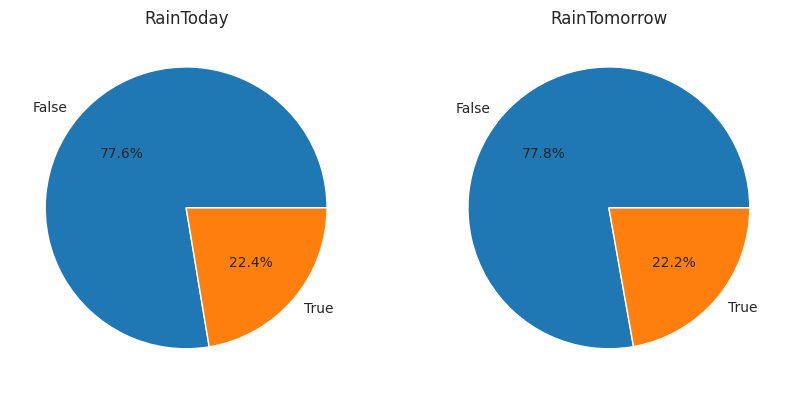

In [ ]:
# Get counts of unique values in RainToday column
counts_rain_today = df_pandas['RainToday'].value_counts()

# Get counts of unique values in RainTomorrow column
counts_rain_tomorrow = df_pandas['RainTomorrow'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pie(counts_rain_today.values, labels=counts_rain_today.index, autopct='%1.1f%%')
axs[0].set_title("RainToday")

axs[1].pie(counts_rain_tomorrow.values, labels=counts_rain_tomorrow.index, autopct='%1.1f%%')
axs[1].set_title("RainTomorrow")

plt.show()


Fitur "RainToday" dan "RainTomorrow" menunjukkan pola yang mirip. Apakah ada korelasi yang signifikan antara keduanya?

Correlation between raintomorrow and raintoday: 0.3117508984717339


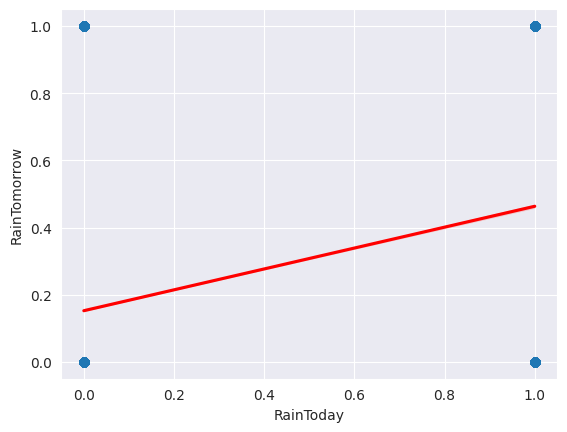

In [ ]:
sns.regplot(x='RainToday', y='RainTomorrow', data=df_pandas, line_kws={'color': 'red'})
correlation = df_pandas['RainTomorrow'].corr(df_pandas['RainToday'])
print('Correlation between raintomorrow and raintoday:', correlation)

Berdasarkan perhitungan koefisien korelasi, terdapat korelasi yang lemah antara fitur RainToday dan RainTomorrow, yang menunjukkan bahwa keduanya tidak memiliki hubungan yang kuat.

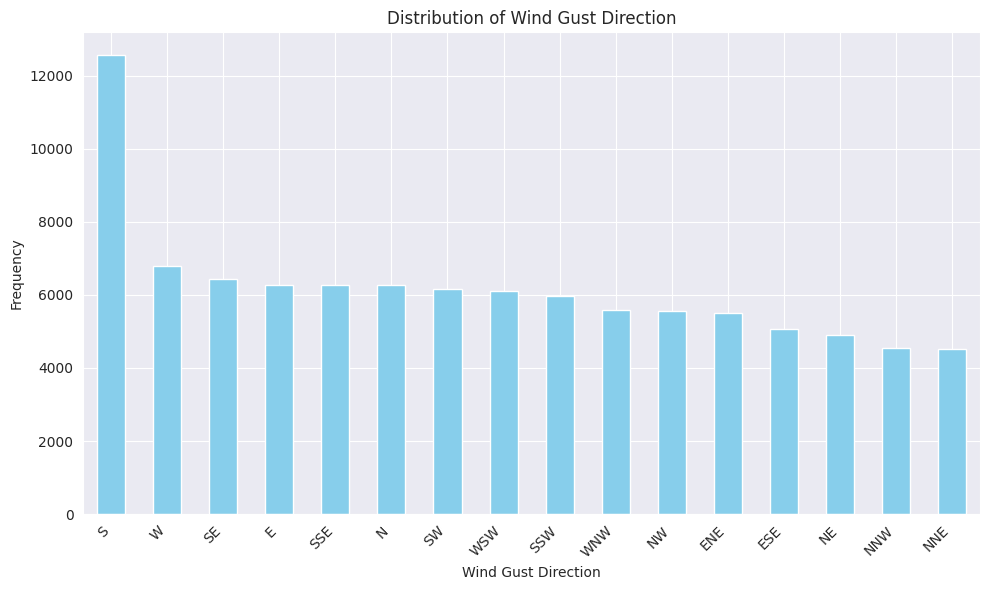

In [ ]:
import matplotlib.pyplot as plt

wind_gust_distribution = df_pandas.groupby("WindGustDir").size().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
wind_gust_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Wind Gust Direction')
plt.xlabel('Wind Gust Direction')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Arah angin kencang yang paling sering adalah dari (NNW), yang terjadi sekitar 12.000 kali dalam dataset. Hal ini menunjukkan pola angin dominan yang cenderung dari arah barat di daerah tersebut.

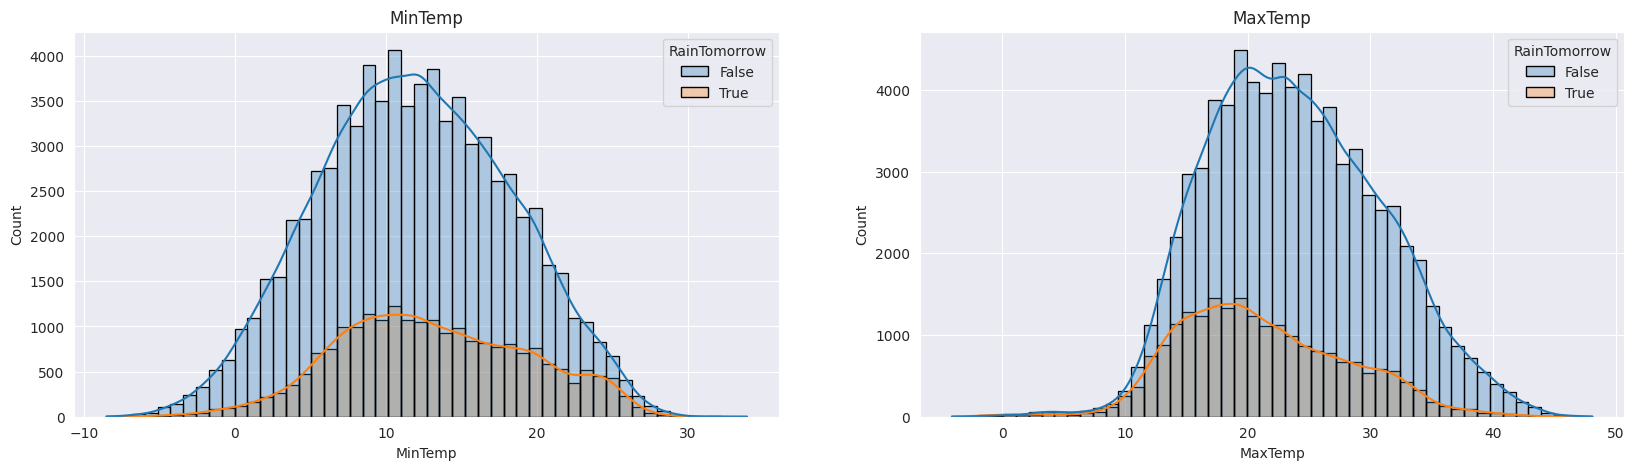

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(data=df_pandas, x='MinTemp', ax=axs[0], bins=50, kde=True, hue='RainTomorrow' ,edgecolor='black',alpha=0.3)
axs[0].set_title('MinTemp')
sns.histplot(data=df_pandas, x='MaxTemp', ax=axs[1], bins=50,kde=True,edgecolor='black',hue='RainTomorrow' ,alpha=0.3)
axs[1].set_title('MaxTemp')
plt.show()


Berdasarkan perbandingan garis KDE untuk RainTomorrow=False dan RainTomorrow=True pada kedua plot di grafik, tampaknya suhu memiliki pengaruh yang sangat kecil atau bahkan tidak berpengaruh terhadap kemungkinan hujan besok. Kesamaan garis-garis tersebut menunjukkan bahwa suhu bukanlah faktor signifikan dalam memprediksi hujan besok.

Berdasarkan distribusi Suhu Minimum dan Suhu Maksimum, terlihat bahwa sebagian besar Suhu Minimum berada dalam rentang 8-12°C, sedangkan sebagian besar Suhu Maksimum berada dalam rentang 18-22°C. Rentang ini mewakili nilai yang paling umum untuk masing-masing variabel suhu, sebagaimana dibuktikan oleh puncak pada grafik distribusi.

In [ ]:
correlation = df_pandas['RainTomorrow'].corr(df_pandas['MinTemp'])
print('Correlation between RainTomorrow and MinTemp:', correlation)
correlation = df_pandas['RainTomorrow'].corr(df_pandas['MaxTemp'])
print('Correlation between RainTomorrow and MaxTemp:', correlation)

Correlation between RainTomorrow and MinTemp: 0.08479583945039088
Correlation between RainTomorrow and MaxTemp: -0.15949000840553504


**Temperature Variation**

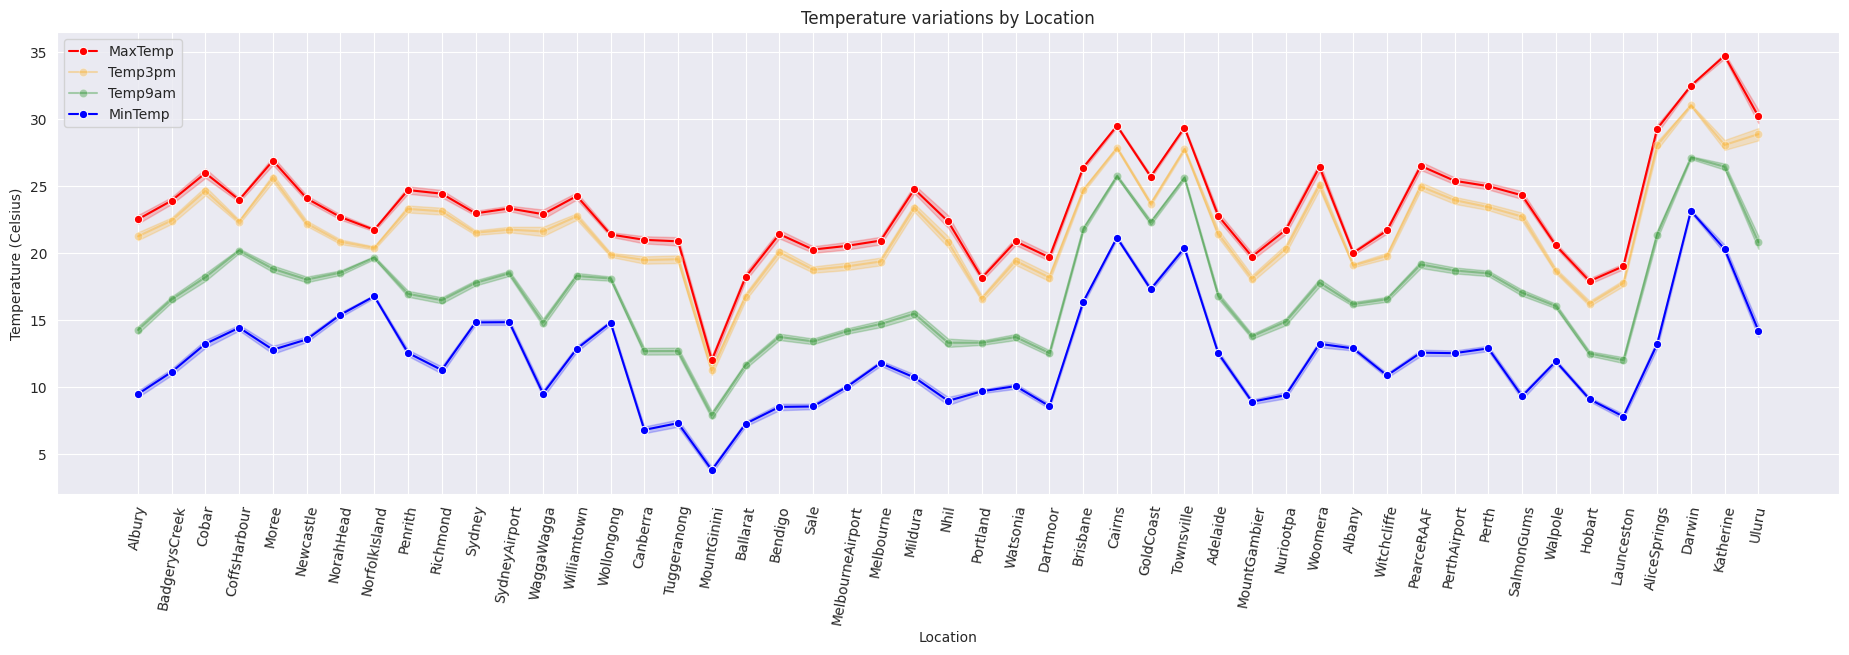

In [ ]:
fig, ax = plt.subplots(figsize=(23,6))
sns.lineplot(x="Location", y="MaxTemp",  data=df_pandas, ax=ax,color='red',marker='o',label='MaxTemp')
sns.lineplot(x="Location", y="Temp3pm", data=df_pandas, ax=ax,color='orange',marker='o',label='Temp3pm',alpha=0.3)
sns.lineplot(x="Location", y="Temp9am",  data=df_pandas, ax=ax,color='green',marker='o',label='Temp9am',alpha=0.3)
sns.lineplot(x="Location", y="MinTemp", data=df_pandas, ax=ax,color='blue',marker='o',label='MinTemp')
ax.set(title="Temperature variations by Location")
plt.ylabel('Temperature (Celsius)')
plt.xticks(rotation=80)
plt.show()

Berdasarkan data suhu, Australia umumnya mengalami kondisi cuaca yang stabil, dengan hanya beberapa lokasi ekstrem, seperti 'MountGinini', yang cenderung memiliki suhu terdingin, dan 'Katherine', yang cenderung memiliki suhu terpanas.

Selain itu, terdapat korelasi yang kuat antara suhu maksimum harian dengan suhu pada pukul 3 sore. Hal ini menunjukkan bahwa suhu tertinggi biasanya terjadi pada sore hari.

**Wind Speed Variation**

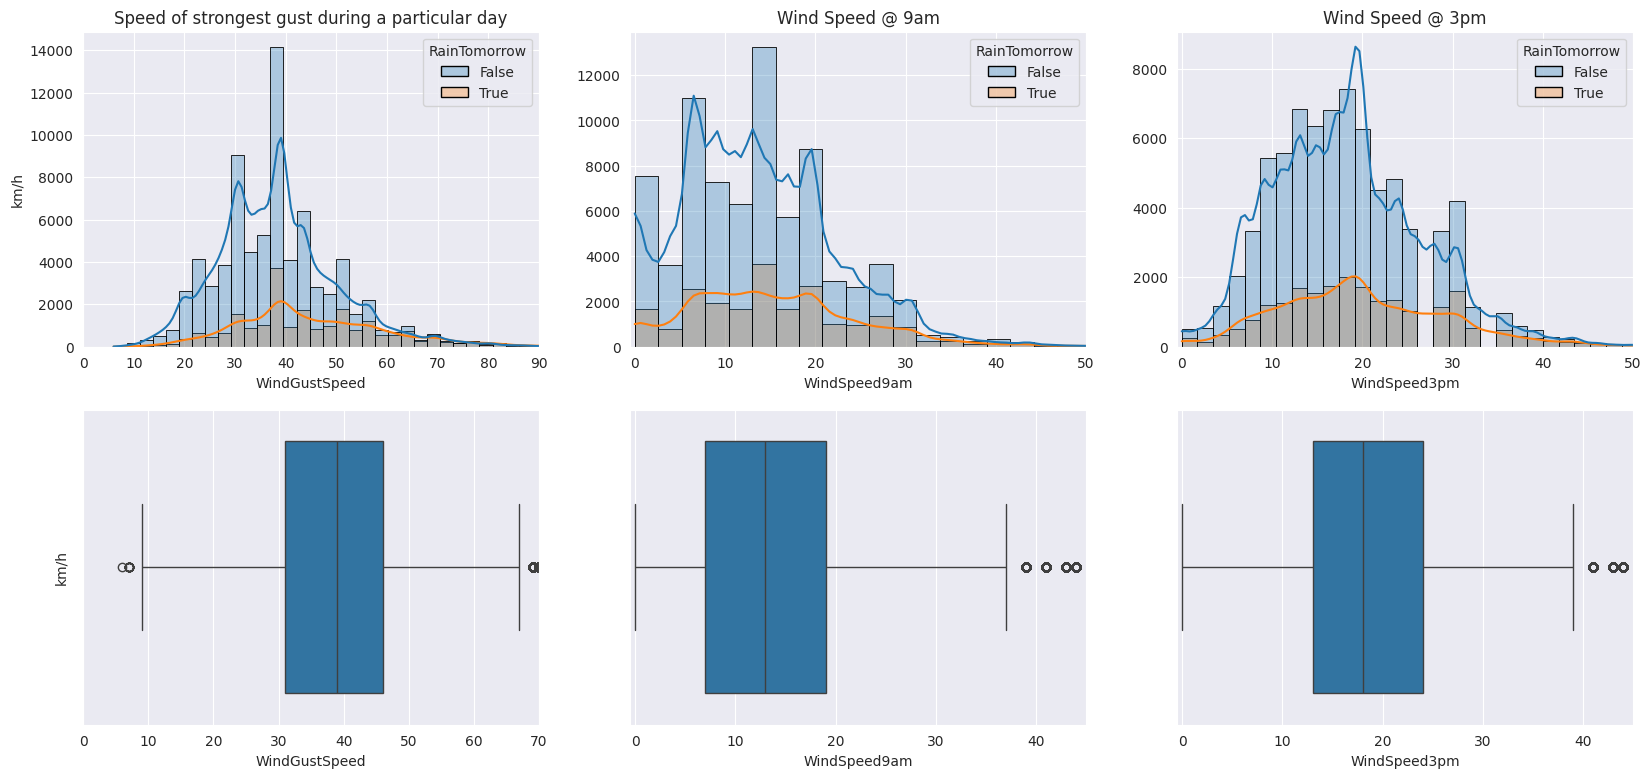

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 9))

sns.histplot(data=df_pandas, x='WindGustSpeed', ax=axs[0, 0], bins=50, kde=True, hue='RainTomorrow', edgecolor='black', alpha=0.3)
axs[0, 0].set_title('Speed of strongest gust during a particular day')
axs[0, 0].set_ylabel('km/h')
axs[0, 0].set_xlim([0, 90])

sns.histplot(data=df_pandas, x='WindSpeed9am', ax=axs[0, 1], bins=50, kde=True, hue='RainTomorrow', edgecolor='black', alpha=0.3)
axs[0, 1].set_title('Wind Speed @ 9am')
axs[0, 1].set_ylabel('')
axs[0, 1].set_xlim([-0.5, 50])

sns.histplot(data=df_pandas, x='WindSpeed3pm', ax=axs[0, 2], bins=50, kde=True, hue='RainTomorrow', edgecolor='black', alpha=0.3)
axs[0, 2].set_title('Wind Speed @ 3pm')
axs[0, 2].set_xlim([-0.5, 50])
axs[0, 2].set_ylabel('')

sns.boxplot(x=df_pandas['WindGustSpeed'],ax=axs[1,0])
axs[1, 0].set_ylabel('km/h')
axs[1, 0].set_xlim([0, 70])

sns.boxplot(x=df_pandas['WindSpeed9am'],ax=axs[1,1])
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlim([-0.5, 45])

sns.boxplot(x=df_pandas['WindSpeed3pm'],ax=axs[1,2])
axs[1, 2].set_ylabel('')
axs[1, 2].set_xlim([-0.5, 45])

plt.show()


Analisis data WindGust, WindSpeed9am, dan WindSpeed3pm menunjukkan bahwa:



*   WindGust biasanya berada dalam rentang 30 hingga 45 km/jam, dengan frekuensi
tertinggi pada 40 km/jam.
*   WindSpeed9am memiliki rentang yang lebih sempit, yaitu 7 hingga 20 km/jam, dengan frekuensi tertinggi pada 15 km/jam.
*   WindSpeed3pm berada dalam rentang 13 hingga 24 km/jam, dengan frekuensi tertinggi pada 20 km/jam.



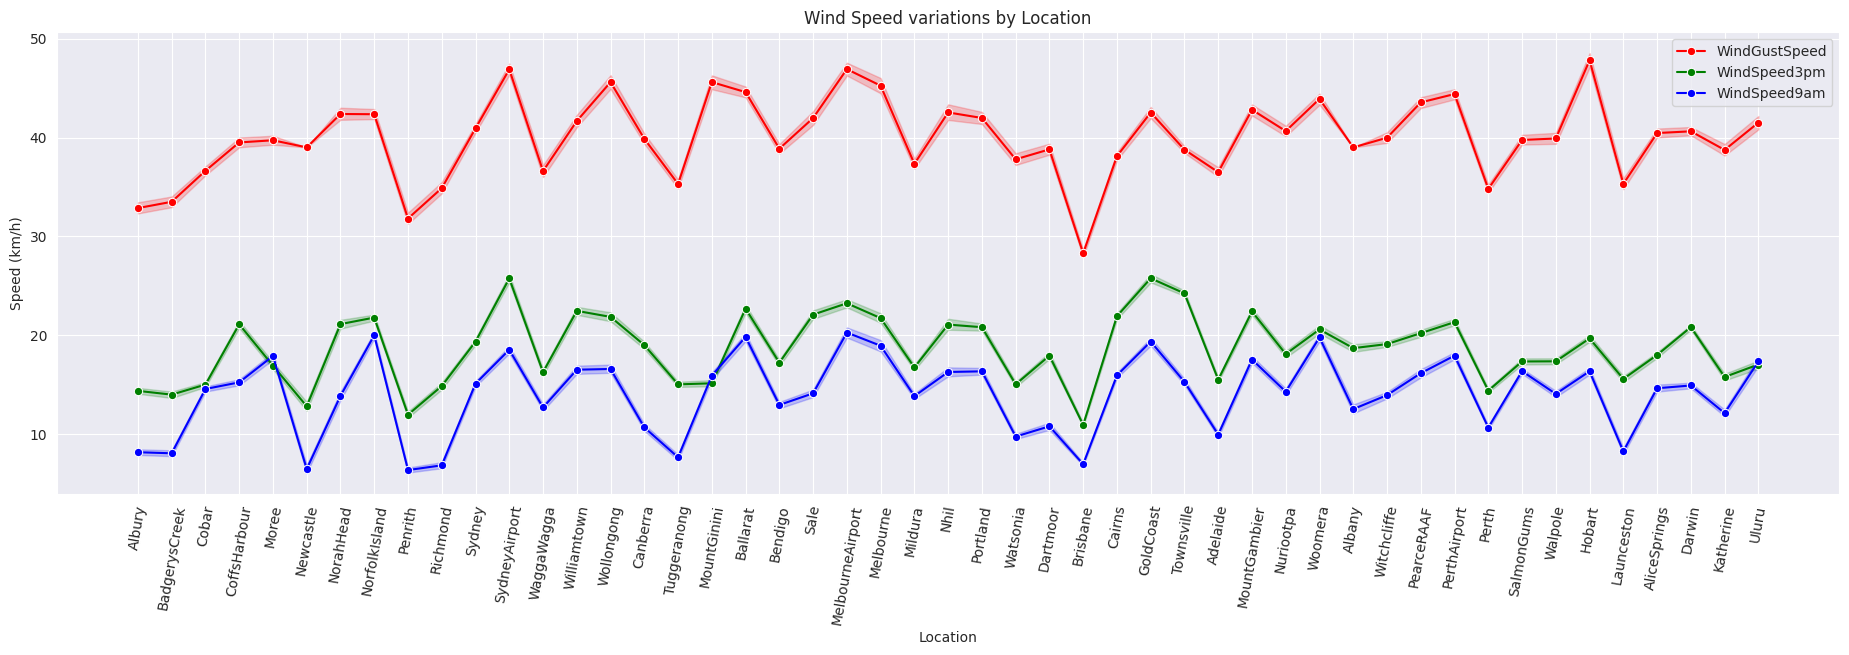

In [ ]:
fig, ax = plt.subplots(figsize=(23,6))
sns.lineplot(x="Location", y="WindGustSpeed",  data=df_pandas, ax=ax,color='red',marker='o',label='WindGustSpeed')
sns.lineplot(x="Location", y="WindSpeed3pm", data=df_pandas, ax=ax,color='green',marker='o',label='WindSpeed3pm')
sns.lineplot(x="Location", y="WindSpeed9am",  data=df_pandas, ax=ax,color='blue',marker='o',label='WindSpeed9am')
ax.set(title="Wind Speed variations by Location")
plt.ylabel('Speed (km/h)')
plt.xticks(rotation=80)
plt.show()

**Pressure Variation**

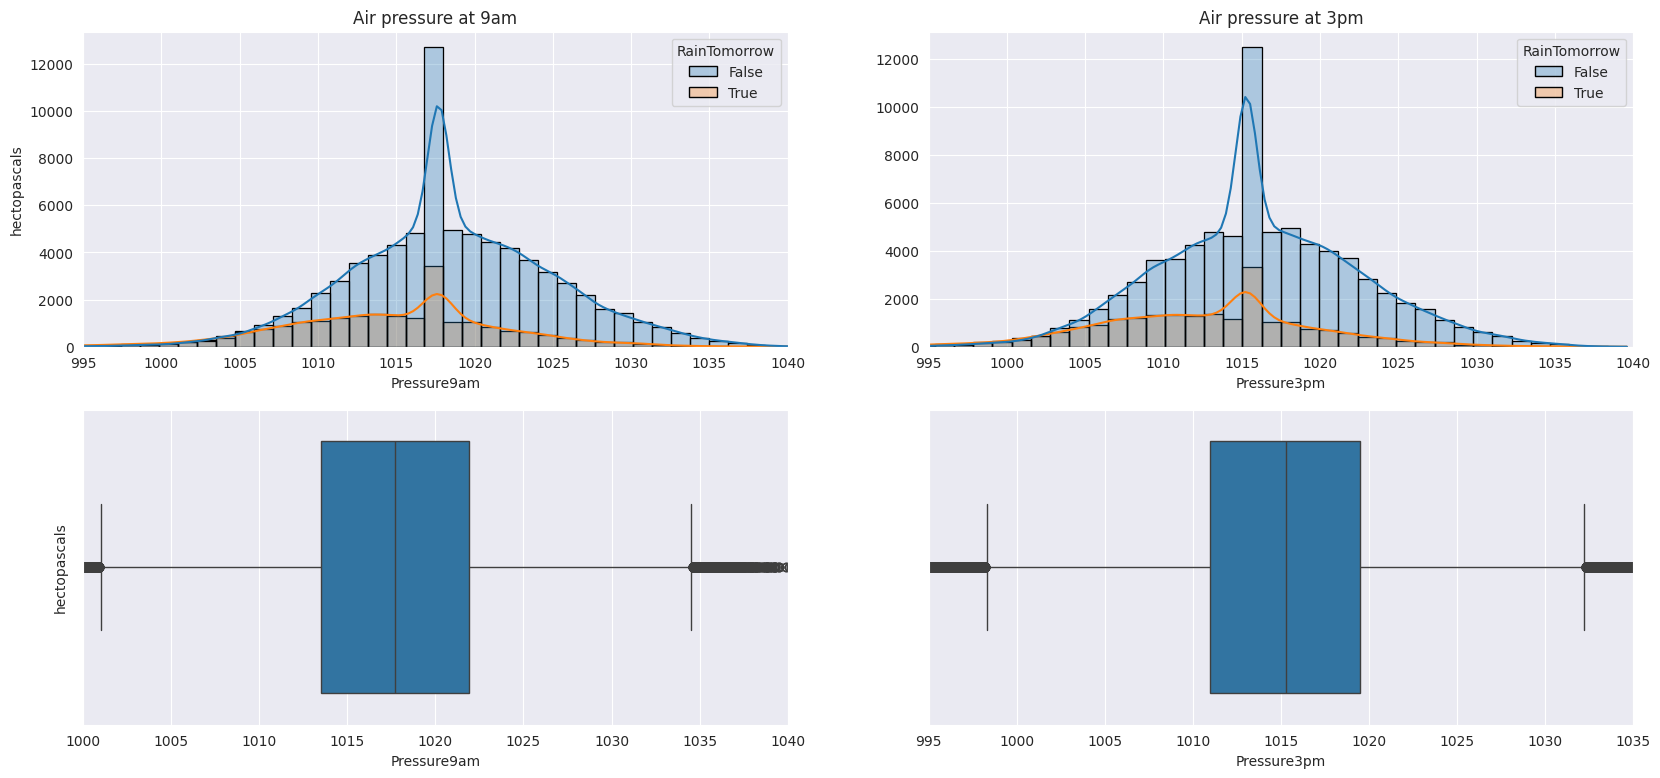

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 9))

sns.histplot(data=df_pandas, x='Pressure9am', ax=axs[0, 0], bins=50, kde=True, hue='RainTomorrow', edgecolor='black', alpha=0.3)
axs[0, 0].set_title('Air pressure at 9am')
axs[0, 0].set_ylabel('hectopascals')
axs[0, 0].set_xlim([995, 1040])

sns.histplot(data=df_pandas, x='Pressure3pm', ax=axs[0, 1], bins=50, kde=True, hue='RainTomorrow', edgecolor='black', alpha=0.3)
axs[0, 1].set_title('Air pressure at 3pm')
axs[0, 1].set_ylabel('')
axs[0, 1].set_xlim([995, 1040])

sns.boxplot(x=df_pandas['Pressure9am'], ax=axs[1, 0])
axs[1, 0].set_ylabel('hectopascals')
axs[1, 0].set_xlim([1000, 1040])

sns.boxplot(x=df_pandas['Pressure3pm'], ax=axs[1, 1])
axs[1, 1].set_ylabel('')
axs[1, 1].set_xlim([995, 1035])

plt.show()


Analisis data Air Pressure menunjukkan bahwa terdapat perbedaan yang relatif kecil antara pembacaan tekanan udara pada pukul 9 pagi dan 3 sore. Rata-rata, tekanan udara pada pukul 9 pagi sekitar 1018 Hektopascal, dan sedikit menurun menjadi sekitar 1015 Hektopascal pada pukul 3 sore. Konsistensi ini menunjukkan bahwa tidak ada gangguan atmosfer yang signifikan sepanjang hari yang dapat menyebabkan perubahan tekanan secara tiba-tiba.

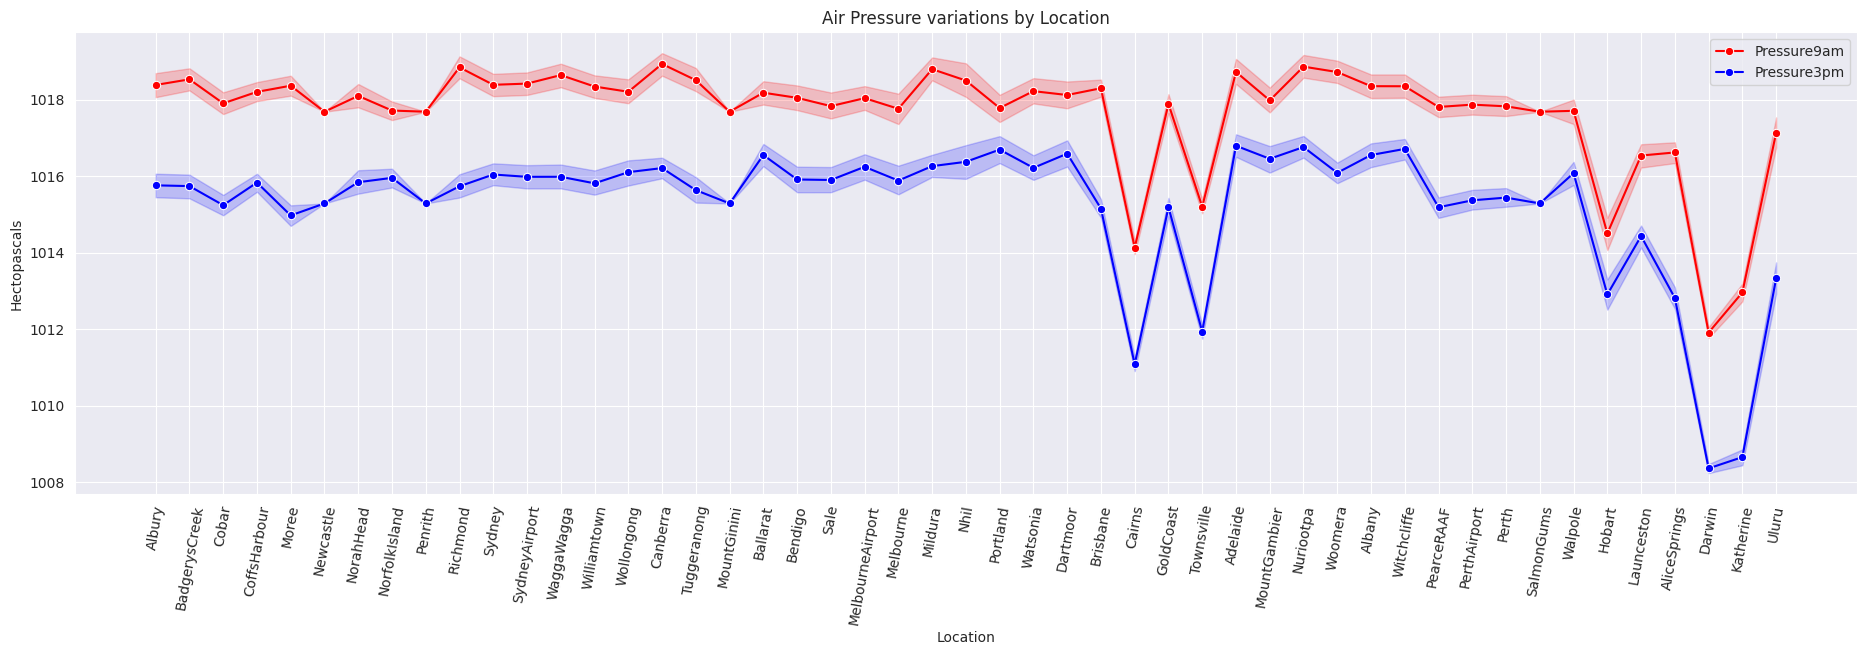

In [ ]:
fig, ax = plt.subplots(figsize=(23,6))
sns.lineplot(x="Location", y="Pressure9am",  data=df_pandas, ax=ax,color='red',marker='o',label='Pressure9am')
sns.lineplot(x="Location", y="Pressure3pm",  data=df_pandas, ax=ax,color='blue',marker='o',label='Pressure3pm')
ax.set(title="Air Pressure variations by Location")
plt.ylabel('Hectopascals')
plt.xticks(rotation=80)
plt.show()

**Humidity Variation**

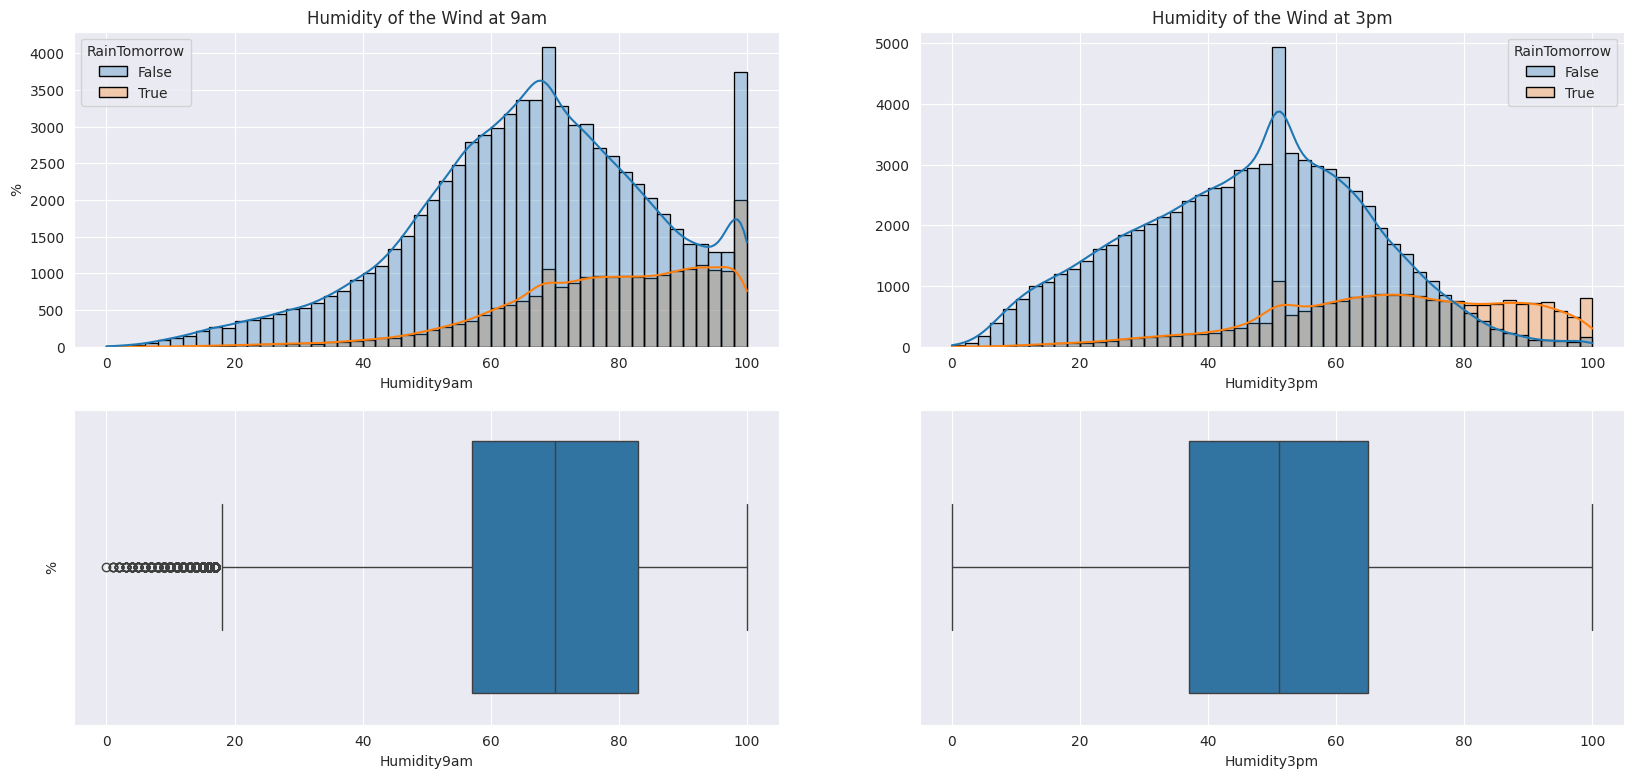

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 9))

sns.histplot(data=df_pandas, x='Humidity9am', ax=axs[0, 0], bins=50, kde=True, hue='RainTomorrow', edgecolor='black', alpha=0.3)
axs[0, 0].set_title('Humidity of the Wind at 9am')
axs[0, 0].set_ylabel('%')

sns.histplot(data=df_pandas, x='Humidity3pm', ax=axs[0, 1], bins=50, kde=True, hue='RainTomorrow', edgecolor='black', alpha=0.3)
axs[0, 1].set_title('Humidity of the Wind at 3pm')
axs[0, 1].set_ylabel('')

sns.boxplot(x=df_pandas['Humidity9am'], ax=axs[1, 0])
axs[1, 0].set_ylabel('%')

sns.boxplot(x=df_pandas['Humidity3pm'], ax=axs[1, 1])
axs[1, 1].set_ylabel('')

plt.show()

Analisis data menunjukkan adanya korelasi kuat antara tingkat kelembapan pada pukul 9 pagi dan 3 sore dengan peluang hujan esok hari. Secara spesifik, kelembapan yang lebih tinggi pada waktu tersebut berhubungan dengan peningkatan kemungkinan hujan di hari berikutnya.

Korelasi ini menyoroti peran penting kelembapan dalam memprediksi kondisi cuaca. Ketika kelembapan meningkat, udara menjadi lebih jenuh dengan uap air, sehingga meningkatkan kemungkinan terjadinya presipitasi. Dengan memantau tingkat kelembapan, terutama pada pukul 9 pagi dan 3 sore, para peramal cuaca dapat memprediksi peluang dan intensitas hujan dengan lebih baik di hari-hari mendatang.

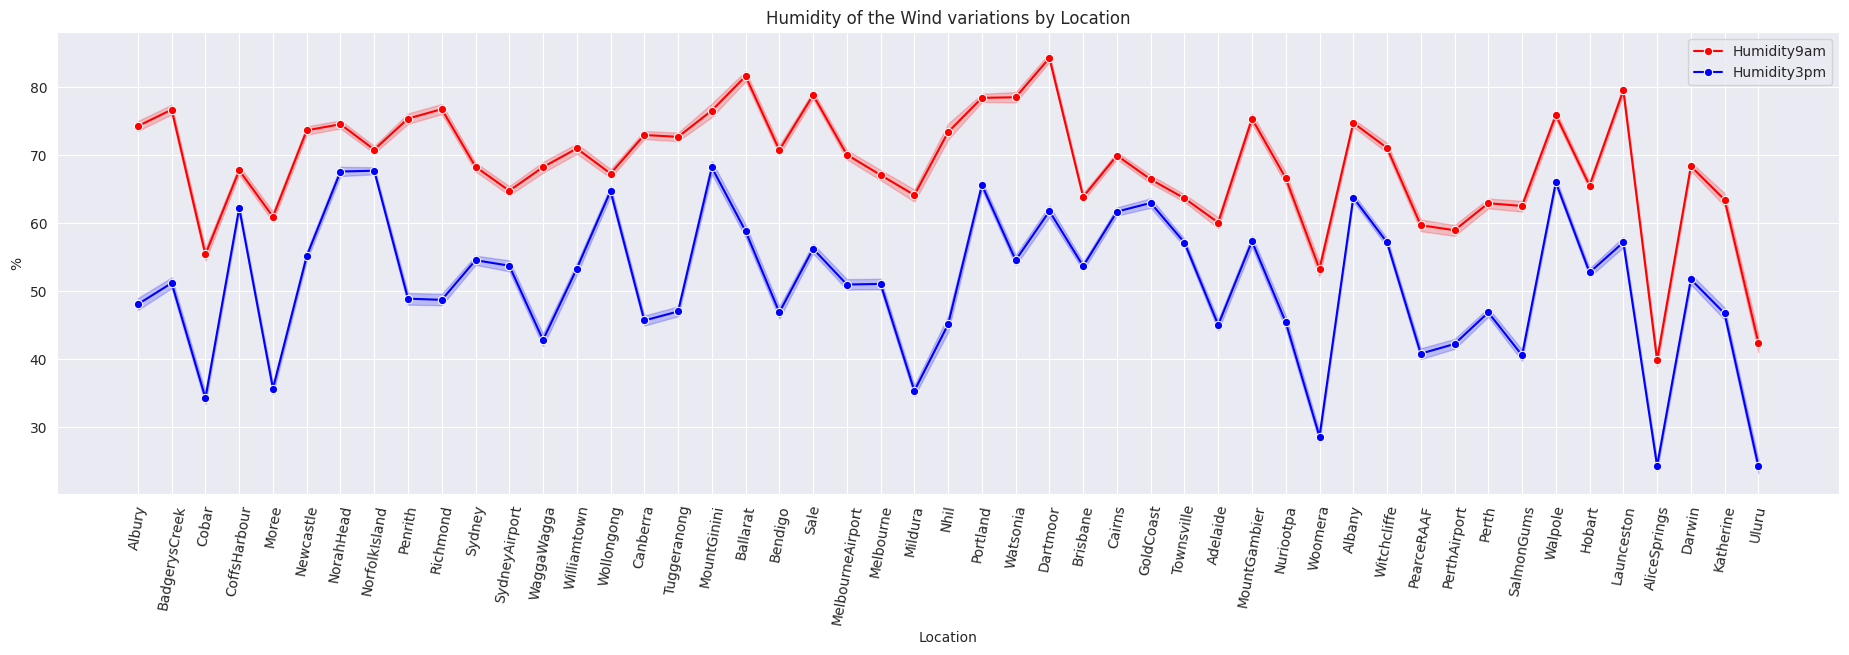

In [ ]:
fig, ax = plt.subplots(figsize=(23,6))
sns.lineplot(x="Location", y="Humidity9am",  data=df_pandas, ax=ax,color='red',marker='o',label='Humidity9am')
sns.lineplot(x="Location", y="Humidity3pm",  data=df_pandas, ax=ax,color='blue',marker='o',label='Humidity3pm')
ax.set(title="Humidity of the Wind variations by Location")
plt.ylabel('%')
plt.xticks(rotation=80)
plt.show()


**Rainfall Variation**

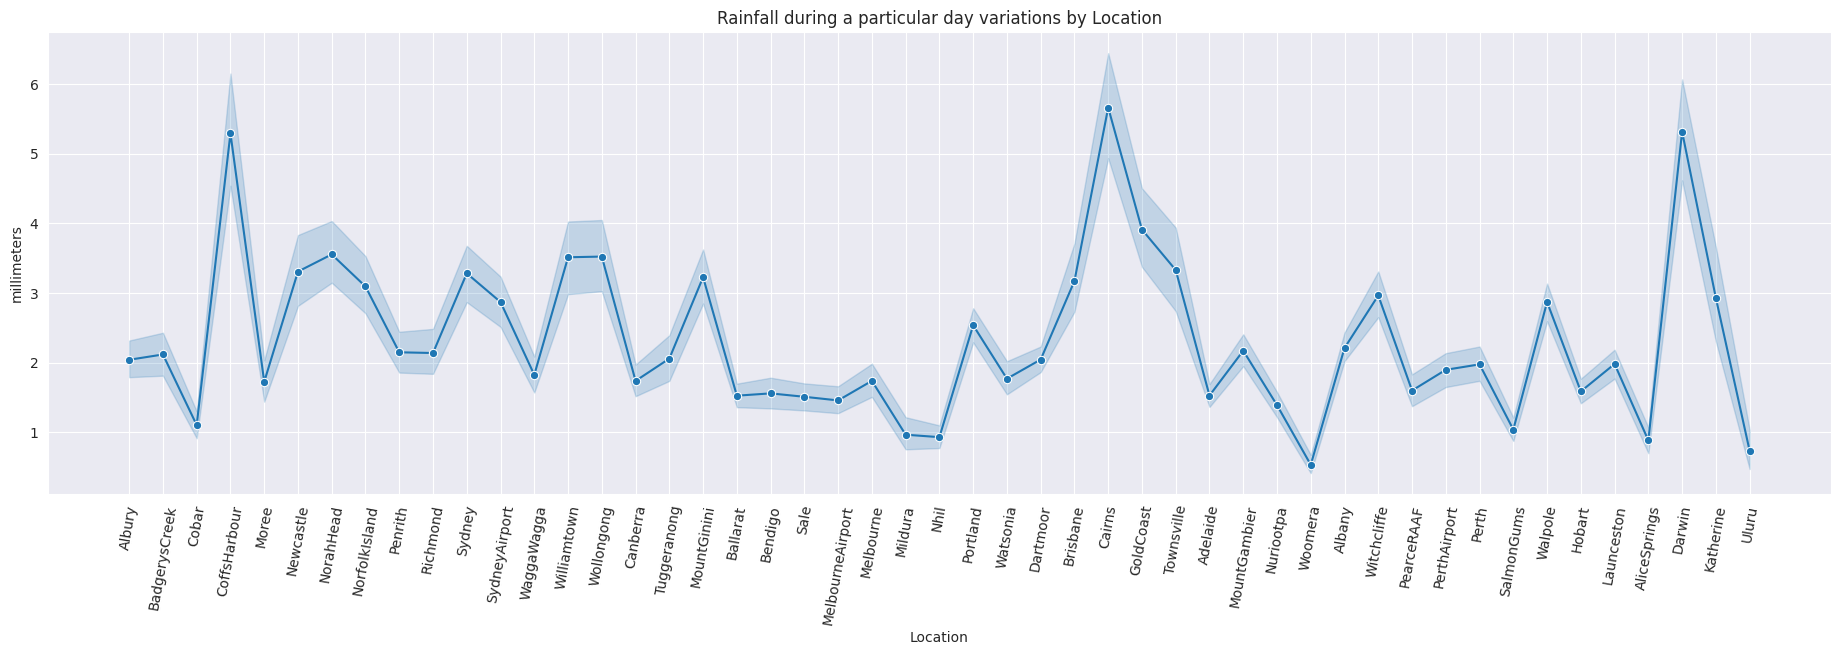

In [ ]:
fig, ax = plt.subplots(figsize=(23,6))
sns.lineplot(x="Location", y="Rainfall",  data=df_pandas, ax=ax,marker='o')
ax.set(title="Rainfall during a particular day variations by Location")
plt.ylabel('millimeters')
plt.xticks(rotation=80)
plt.show()

Analisis data curah hujan menunjukkan bahwa kota-kota seperti **'CoffsHarbour'**, **'Cairns'**, dan **'Darwin'** mengalami curah hujan yang secara signifikan lebih tinggi dibandingkan kota-kota lain dalam dataset. Kota-kota ini berada di wilayah dengan tingkat presipitasi yang tinggi dan dikenal memiliki iklim tropis yang subur.

## **Meachine Learning**

**Correlation Between Numerical Columns**

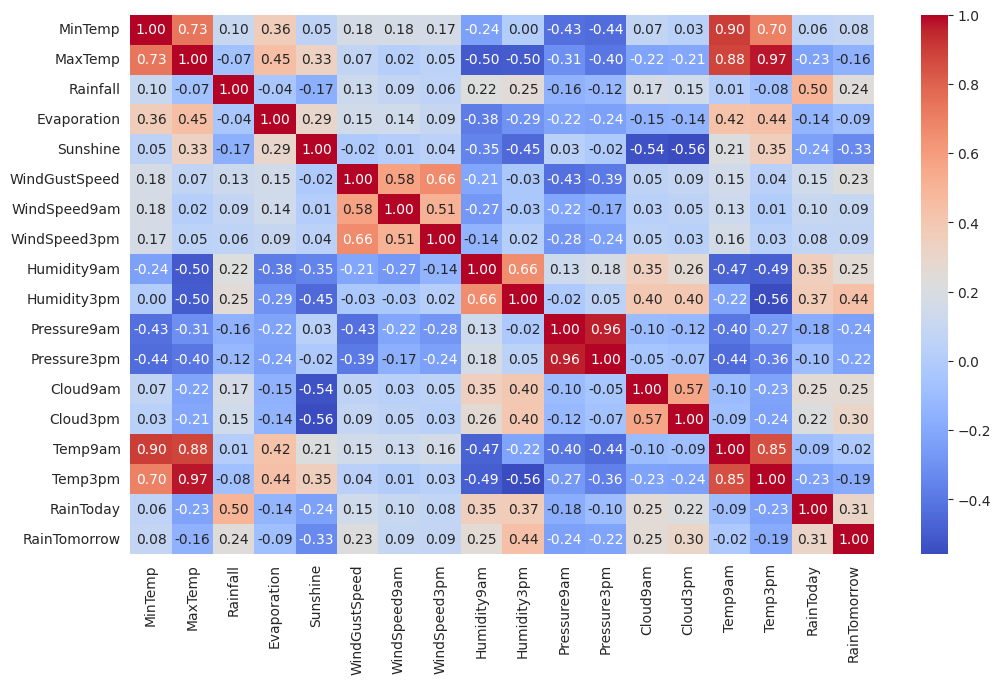

In [ ]:
df_num = df_pandas.select_dtypes(include=['float64', 'int32', 'bool']) # Select numerical and boolean columns

cor = df_num.corr() # Compute correlation matrix

plt.figure(figsize=(12, 7))
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

**Changing Categorical Columns to Numerical**

In [ ]:
import pandas as pd

# Menggunakan pd.get_dummies untuk mengubah kolom kategori menjadi variabel dummy
column_to_change = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_pandas_dummies = pd.get_dummies(df_pandas[column_to_change])

# Mengonversi nilai True menjadi 1 dan False menjadi 0 (secara eksplisit)
df_pandas_dummies = df_pandas_dummies.astype(int)

# Melihat hasilnya
df_pandas_dummies.head()


,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_pandas_dummies = pd.concat([df_pandas.drop(column_to_change, axis=1), df_pandas_dummies], axis=1)
df_pandas_dummies.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,5.46132,7.61509,44,20,24,71,22,...,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,5.46132,7.61509,44,4,22,44,25,...,0,0,0,0,0,0,0,0,0,1
2,17.5,32.3,1.0,5.46132,7.61509,41,7,20,82,33,...,0,1,0,0,0,0,0,0,0,0
3,14.6,29.7,0.2,5.46132,7.61509,56,19,24,55,23,...,0,0,0,0,0,0,0,1,0,0
4,7.7,26.7,0.0,5.46132,7.61509,35,6,17,48,19,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df_pandas_dummies['RainTomorrow'] = df_pandas_dummies.pop('RainTomorrow')
df_pandas_dummies

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainTomorrow
0,13.4,22.9,0.6,5.46132,7.61509,44,20,24,71,22,...,0,0,0,0,0,0,0,1,0,False
1,7.4,25.1,0.0,5.46132,7.61509,44,4,22,44,25,...,0,0,0,0,0,0,0,0,1,False
2,17.5,32.3,1.0,5.46132,7.61509,41,7,20,82,33,...,1,0,0,0,0,0,0,0,0,False
3,14.6,29.7,0.2,5.46132,7.61509,56,19,24,55,23,...,0,0,0,0,0,0,1,0,0,False
4,7.7,26.7,0.0,5.46132,7.61509,35,6,17,48,19,...,0,0,0,0,0,0,1,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98532,8.0,20.7,0.0,5.46132,7.61509,41,19,26,56,32,...,0,0,0,0,0,0,0,0,0,False
98533,3.5,21.8,0.0,5.46132,7.61509,31,15,13,59,27,...,0,0,0,0,0,0,0,0,0,False
98534,2.8,23.4,0.0,5.46132,7.61509,31,13,11,51,24,...,0,0,0,0,0,0,0,0,0,False
98535,3.6,25.3,0.0,5.46132,7.61509,22,13,9,56,21,...,0,0,0,0,0,0,0,0,0,False


In [ ]:
df_final = spark.createDataFrame(df_pandas_dummies)
df_final.show(5)

+-------+-------+--------+-----------------+-----------------+-------------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-----------------+---------------+---------------+---------------------+----------------------+-----------------+----------------+-----------------+---------------+-----------------+--------------+---------------------+-----------------+---------------+------------------+---------------+------------------+-------------------+------------------+-------------------------+----------------+--------------+---------------------+--------------------+------------------+-------------+------------------+----------------------+------------------+-------------------+----------------+--------------+---------------------+-----------------+-----------------+-------------+-------------------+---------------+----------------------+-------------------+--------------------+--------------+-------------------+------

## **Model**

Untuk Klasifikasi dalam dataset ini, kita akan menggunakan:

*   Random Forest Classifier
*   Gradient-Boosted Tree Classifier
*   Logistic Regression
*   Desicison Tree Classifier





In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier,DecisionTreeClassifier,GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

In [ ]:
df_final = df_final.withColumn("RainTomorrow", col("RainTomorrow").cast("int")) # Changing Target column from Boolean to Integer for Training

In [ ]:
(trainingData, testData) = df_final.randomSplit([0.7, 0.3], seed=42) # Splitting Dataset into Training & Testing Dataframes (70-30)

In [ ]:
assembler = VectorAssembler(inputCols=trainingData.columns[:-1], outputCol='features') # Defining Target & Features

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="RainTomorrow") # Initializing Evaluator

### **Random Forest Classifier Model**

In [ ]:
# Membuat model Random Forest
rf = RandomForestClassifier(numTrees=100, maxDepth=4, labelCol="RainTomorrow", seed=42)

# Membuat pipeline dengan assembler dan Random Forest Classifier
rf_model = Pipeline(stages=[assembler, rf]).fit(trainingData)

# Prediksi menggunakan model
rf_preds = rf_model.transform(testData)

# Evaluasi model menggunakan BinaryClassificationEvaluator
rf_score = evaluator.evaluate(rf_preds)

# Evaluasi menggunakan BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="RainTomorrow", metricName="areaUnderROC")

# Mengambil data ROC untuk visualisasi
roc = rf_preds.select("probability", "RainTomorrow").rdd.map(lambda row: (float(row['probability'][1]), float(row['RainTomorrow']))).toDF(["probability", "label"])

# Tambahkan kolom 'features' ke DataFrame hasil prediksi
rf_preds = rf_preds.select('RainTomorrow', 'prediction', 'features')

# Ubah nama kolom 'RainTomorrow' menjadi 'label' agar sesuai dengan evaluator
rf_preds = rf_preds.withColumnRenamed('RainTomorrow', 'label')

# Konversi ke format RDD
rf_preds_rdd = rf_preds.rdd.map(lambda x: (float(x['prediction']), float(x['label']), x['features']))

# Buat kembali DataFrame dengan kolom 'prediction', 'label', dan 'features'
rf_preds = spark.createDataFrame(rf_preds_rdd, ['prediction', 'label', 'features'])

# Tampilkan DataFrame hasil prediksi
rf_preds.show(n=5, truncate=False)

rf_preds.groupby('label', 'prediction').count().show()

print("Random Forest Classifier accuracy:", rf_score)

# Evaluasi akurasi
from pyspark.ml.evaluation import BinaryClassificationEvaluator


+----------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|prediction|label|features                                                                                                                                                                                                              |
+----------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0.0       |0.0  |(114,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,26,74,88,105],[-8.0,15.1,0.2,2.6,7.9,39.0,6.0,13.0,96.0,33.0,1029.6,1025.3,1.0,4.0,-1.2,14.5,1.0,1.0,1.0,1.0])                                                            |
|0.0       |0.0  |(114,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,40

**Random Forest Classifier Model**

In [ ]:
# Membuat model Random Forest
rf = RandomForestClassifier(
    numTrees=100,
    maxDepth=4,
    labelCol="RainTomorrow",
    seed=42,
    rawPredictionCol="rawPrediction",
    probabilityCol="probability" # This line is added to specify the column name for probability
)

# Membuat pipeline dengan assembler dan Random Forest Classifier
rf_model = Pipeline(stages=[assembler, rf]).fit(trainingData)

# Prediksi menggunakan model
rf_preds = rf_model.transform(testData)

# Evaluasi model menggunakan BinaryClassificationEvaluator
rf_score = evaluator.evaluate(rf_preds)

# Tambahkan kolom 'features' ke DataFrame hasil prediksi
rf_preds = rf_preds.select('RainTomorrow', 'prediction', 'probability', 'features') #Include the probability column

# Ubah nama kolom 'RainTomorrow' menjadi 'label' agar sesuai dengan evaluator
rf_preds = rf_preds.withColumnRenamed('RainTomorrow', 'label')

# Konversi ke format RDD untuk menyesuaikan proses sebelumnya
rf_preds = rf_preds.rdd.map(lambda x: (float(x['prediction']), float(x['label']), x['features'],x['probability'])) #Include the probability column

# Buat kembali DataFrame dengan kolom 'prediction', 'label', dan 'features'
rf_preds = spark.createDataFrame(rf_preds, ['prediction', 'label', 'features', 'probability']) #Include the probability column

# Tampilkan DataFrame hasil prediksi
rf_preds.show(n=5, truncate=False)

rf_preds.groupby('label', 'prediction').count().show()

print("Random Forest Classifier accuracy:", rf_score)

+----------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+
|prediction|label|features                                                                                                                                                                                                              |probability                             |
+----------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+
|0.0       |0.0  |(114,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,26,74,88,105],[-8.0,15.1,0.2,2.6,7.9,39.0,6.0,13.0,96.0,33.0,1029.6,1025.3,1.0,4.0,-1.2,14.5,1.0,1.0,1.0,1.0])   

### **Gradient-Boosted Tree Classifier Model**

In [ ]:
# Membuat model Gradient-Boosted Tree Classifier
gbt = GBTClassifier(featuresCol='features', labelCol='RainTomorrow', maxIter=10, maxDepth=3) # Remove probabilityCol

# Membuat pipeline dengan assembler dan GBT Classifier
gbt_model = Pipeline(stages=[assembler, gbt]).fit(trainingData)

# Prediksi menggunakan model
gbt_preds = gbt_model.transform(testData)


# Evaluasi model menggunakan BinaryClassificationEvaluator dengan rawPredictionCol
gbt_score = evaluator.evaluate(gbt_preds, {evaluator.metricName: "areaUnderROC"})


# Menambahkan kolom 'features' ke DataFrame hasil prediksi
gbt_preds = gbt_preds.select('RainTomorrow', 'prediction', 'features')

# Ubah nama kolom 'RainTomorrow' menjadi 'label'
gbt_preds = gbt_preds.withColumnRenamed('RainTomorrow', 'label')

# Menampilkan DataFrame hasil prediksi
gbt_preds.show(n=5, truncate=False)

# Menampilkan jumlah prediksi berdasarkan 'label' dan 'prediction'
gbt_preds.groupby('label', 'prediction').count().show()

# Menampilkan hasil evaluasi
print("Gradient-Boosted Tree Classifier Accuracy:", gbt_score)

+-----+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|prediction|features                                                                                                                                                                                                              |
+-----+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |0.0       |(114,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,26,74,88,105],[-8.0,15.1,0.2,2.6,7.9,39.0,6.0,13.0,96.0,33.0,1029.6,1025.3,1.0,4.0,-1.2,14.5,1.0,1.0,1.0,1.0])                                                            |
|0    |1.0       |(114,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,40

### **Logistic Regression Model**

In [ ]:
# Inisialisasi model Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='RainTomorrow')

# Membuat pipeline dengan assembler dan model
lr_model = Pipeline(stages=[assembler, lr]).fit(trainingData)

# Menggunakan model untuk membuat prediksi pada data uji
lr_preds = lr_model.transform(testData)
lr_score = evaluator.evaluate(lr_preds)


# Evaluasi model dengan BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="RainTomorrow")

# Memilih kolom yang relevan untuk analisis
lr_preds = lr_preds.select('RainTomorrow', 'prediction', 'features')

# Mengubah prediksi menjadi format RDD untuk menghitung frekuensi kombinasi label dan prediksi
lr_preds = lr_preds.rdd.map(lambda x: (float(x[1]), float(x[0]), x[2]))

# Membuat DataFrame baru dengan kolom 'prediction', 'label', dan 'features'
lr_preds = spark.createDataFrame(lr_preds, ['prediction', 'label', 'features'])

# Menampilkan DataFrame hasil prediksi
gbt_preds.show(n=5, truncate=False)

# Menampilkan frekuensi kombinasi label dan prediksi
lr_preds.groupby('label', 'prediction').count().show()

# Menampilkan akurasi model
print("Logistic Regression Classifier Accuracy: ", lr_score)

+-----+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|prediction|features                                                                                                                                                                                                              |
+-----+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |0.0       |(114,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,26,74,88,105],[-8.0,15.1,0.2,2.6,7.9,39.0,6.0,13.0,96.0,33.0,1029.6,1025.3,1.0,4.0,-1.2,14.5,1.0,1.0,1.0,1.0])                                                            |
|0    |1.0       |(114,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,40

### **DecisionTree Classifier Model**

In [ ]:
dt = DecisionTreeClassifier(labelCol="RainTomorrow", featuresCol="features")
dt_model = Pipeline(stages=[assembler, dt]).fit(trainingData)

dt_preds = dt_model.transform(testData)
dt_score = evaluator.evaluate(dt_preds)

dt_preds = dt_model.transform(testData)
dt_preds = dt_preds.select('RainTomorrow', 'prediction')
dt_preds = dt_preds.rdd.map(lambda x: (float(x[1]), float(x[0])))
dt_preds = spark.createDataFrame(dt_preds, ['prediction', 'label'])

dt_preds.groupby('label', 'prediction').count().show()
print("DecisionTree Classifier accuracy:", dt_score)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2707|
|  0.0|       1.0| 1020|
|  1.0|       0.0| 3754|
|  0.0|       0.0|21900|
+-----+----------+-----+

DecisionTree Classifier accuracy: 0.4381251936373241


In [ ]:
# Membuat model DecisionTree
dt = DecisionTreeClassifier(labelCol="RainTomorrow", featuresCol="features")

# Membuat pipeline dengan assembler dan DecisionTree
dt_model = Pipeline(stages=[assembler, dt]).fit(trainingData)

# Prediksi menggunakan model
dt_preds = dt_model.transform(testData)

# Evaluasi model
dt_score = evaluator.evaluate(dt_preds)

# Pilih kolom yang ingin ditampilkan: RainTomorrow, prediction, dan features
dt_preds = dt_preds.select('RainTomorrow', 'prediction', 'features')

# Ubah nama kolom 'RainTomorrow' menjadi 'label' agar sesuai dengan evaluator
dt_preds = dt_preds.withColumnRenamed('RainTomorrow', 'label')

# Konversi ke format RDD untuk menyesuaikan proses sebelumnya
dt_preds = dt_preds.rdd.map(lambda x: (float(x['prediction']), float(x['label']), x['features']))

# Buat kembali DataFrame dengan kolom 'prediction', 'label', dan 'features'
dt_preds = spark.createDataFrame(dt_preds, ['prediction', 'label', 'features'])

# Menampilkan DataFrame hasil prediksi
dt_preds.show(n=5, truncate=False)

# Menampilkan jumlah prediksi berdasarkan 'label' dan 'prediction'
dt_preds.groupby('label', 'prediction').count().show()

# Menampilkan hasil evaluasi
print("DecisionTree Classifier accuracy:", dt_score)


+----------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|prediction|label|features                                                                                                                                                                                                              |
+----------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0.0       |0.0  |(114,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,26,74,88,105],[-8.0,15.1,0.2,2.6,7.9,39.0,6.0,13.0,96.0,33.0,1029.6,1025.3,1.0,4.0,-1.2,14.5,1.0,1.0,1.0,1.0])                                                            |
|0.0       |0.0  |(114,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,40

## **Evaluasi**

#### **Random Forest Classifier Model**

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


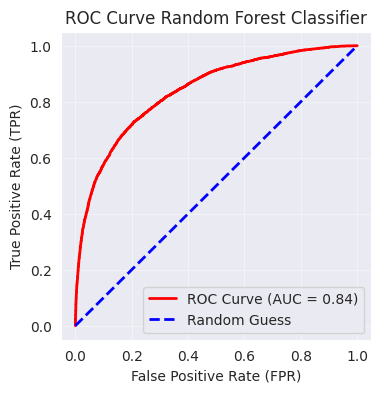

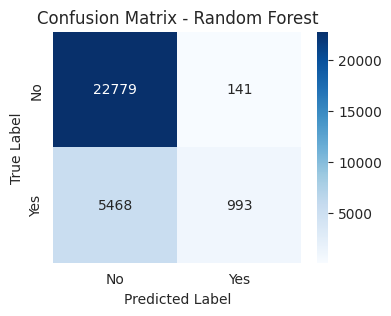

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| AUC/ROC   | 0.839003 |
+-----------+----------+
| Accuracy  | 0.809094 |
+-----------+----------+
| Precision | 0.875661 |
+-----------+----------+
| Recall    | 0.153691 |
+-----------+----------+
| F1 Score  | 0.261488 |
+-----------+----------+


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
import seaborn as sns

# Ekstrak probabilitas dan label dari prediksi
rf_preds_prob = rf_preds.select("probability", "label").rdd.map(lambda row: (float(row['probability'][1]), row['label'])).collect()

# Pisahkan nilai prediksi dan label
y_scores, y_true = zip(*rf_preds_prob)

# Hitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Hitung AUC
roc_auc = auc(fpr, tpr)

# Hitung confusion matrix
rf_preds_rdd = rf_preds.select("prediction", "label").rdd.map(lambda row: (row["prediction"], row["label"]))
metrics = MulticlassMetrics(rf_preds_rdd)

# Dapatkan nilai TP, FP, TN, FN
cm = metrics.confusionMatrix().toArray()

# Plot ROC Curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='red', lw=2, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()

# Buat visualisasi confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Hitung metrik tambahan
accuracy = metrics.accuracy
precision = metrics.precision(1.0)  # Presisi untuk kelas positif (label 1)
recall = metrics.recall(1.0)        # Recall untuk kelas positif (label 1)
f1_score = metrics.fMeasure(1.0)   # F1 Score untuk kelas positif (label 1)

# Tampilkan metrik tambahan dalam bentuk tabel
from tabulate import tabulate
metrics_table = [["AUC/ROC", roc_auc],
                 ["Accuracy", accuracy],
                 ["Precision", precision],
                 ["Recall", recall],
                 ["F1 Score", f1_score]]

print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

####**Gradient-Boosted Tree Classifier Model**

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


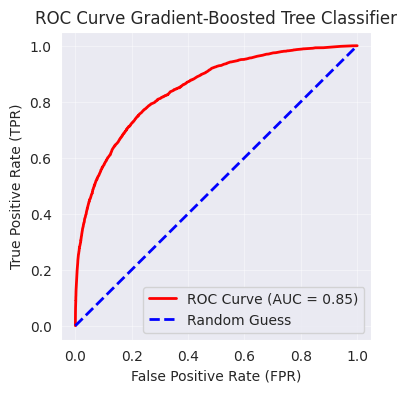

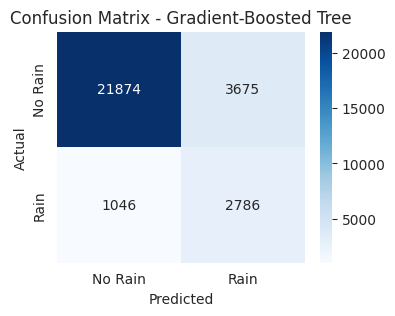

+-----------+----------+
| Metric    |    Value |
+===========+==========+
| AUC/ROC   | 0.845766 |
+-----------+----------+
| Accuracy  | 0.839318 |
+-----------+----------+
| Precision | 0.431203 |
+-----------+----------+
| Recall    | 0.727035 |
+-----------+----------+
| F1 Score  | 0.541339 |
+-----------+----------+


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from sklearn.metrics import roc_curve, auc
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics

# Tambahkan kolom 'label' ke gbt_preds untuk mencocokkan format yang diharapkan
gbt_preds = gbt_preds.withColumnRenamed('RainTomorrow', 'label')

# Prediksi menggunakan model, pastikan untuk menyertakan rawPrediction dan probability
gbt_preds = gbt_model.transform(testData)

# Rename the 'RainTomorrow' column to 'label' after the transform
gbt_preds = gbt_preds.withColumnRenamed('RainTomorrow', 'label')

# Fungsi untuk mengambil probabilitas positif (Rain)
def get_positive_probability(prob):
    return float(prob[1])

# Mendaftarkan fungsi UDF
get_positive_probability_udf = udf(get_positive_probability, DoubleType())

# Menggunakan UDF untuk menambah kolom 'positive_prob', menggunakan rawPrediction
gbt_preds = gbt_preds.withColumn('positive_prob', get_positive_probability_udf(col('rawPrediction')))

# Ambil nilai 'label' dan 'positive_prob'
y_true = gbt_preds.select('label').rdd.flatMap(lambda x: x).collect()
y_score = gbt_preds.select('positive_prob').rdd.flatMap(lambda x: x).collect()

# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Rename the 'RainTomorrow' to 'label' to be consistent with the expected column name
gbt_preds = gbt_preds.withColumnRenamed('RainTomorrow', 'label')

# Cast 'label' and 'prediction' columns to double type
gbt_preds = gbt_preds.withColumn("label", col("label").cast("double"))
gbt_preds = gbt_preds.withColumn("prediction", col("prediction").cast("double"))

# Menghitung Confusion Matrix
roc = gbt_preds.select("label", "prediction")
metrics = MulticlassMetrics(roc.rdd)
conf_matrix = metrics.confusionMatrix().toArray()

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='red', lw=2, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Gradient-Boosted Tree Classifier')
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()

# Plotting Confusion Matrix
plt.figure(figsize=(4, 3))
# Changing the format code to '.0f' to handle floats and display them as integers
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient-Boosted Tree')
plt.show()

# Calculate accuracy, precision, recall, and F1 score for Gradient-Boosted Tree
accuracy = metrics.accuracy
precision = metrics.precision(1.0)  # Presisi untuk kelas positif (label 1)
recall = metrics.recall(1.0)        # Recall untuk kelas positif (label 1)
f1_score = metrics.fMeasure(1.0)   # F1 Score untuk kelas positif (label 1)

# Tampilkan metrik tambahan dalam bentuk tabel
from tabulate import tabulate
metrics_table = [["AUC/ROC", roc_auc],
                 ["Accuracy", accuracy],
                 ["Precision", precision],
                 ["Recall", recall],
                 ["F1 Score", f1_score]]

print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

### **Logistic Regression**

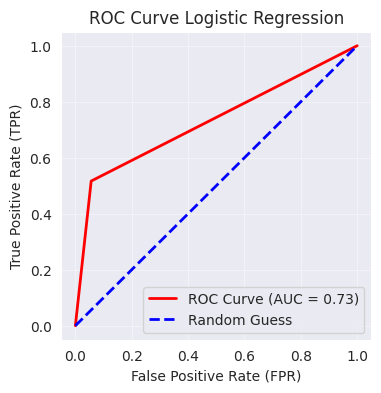

AUC/ROC: 0.73


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ambil nilai 'label' dan 'prediction'
y_true = lr_preds.select('label').rdd.flatMap(lambda x: x).collect()
y_score = lr_preds.select('prediction').rdd.flatMap(lambda x: x).collect()

# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='red', lw=2, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()

# Menampilkan AUC/ROC
print(f"AUC/ROC: {roc_auc:.2f}")

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


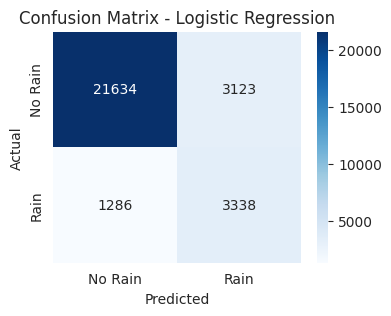

Accuracy: 0.8499
Precision: 0.5166382912861787
Recall: 0.721885813148789
F1-score: 0.602255299954894


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Ubah nama kolom 'RainTomorrow' menjadi 'label'
lr_preds = lr_preds.withColumnRenamed('RainTomorrow', 'label')

# Cast 'label' dan 'prediction' columns to double type
lr_preds = lr_preds.withColumn("label", col("label").cast("double"))
lr_preds = lr_preds.withColumn("prediction", col("prediction").cast("double"))

# Hitung confusion matrix
metrics = MulticlassMetrics(lr_preds.select("label", "prediction").rdd)
conf_matrix = metrics.confusionMatrix().toArray()

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Accuracy, Precision, Recall, dan F1-Score
accuracy = metrics.accuracy
print(f"Accuracy: {accuracy:.4f}")
print("Precision:", metrics.precision(1.0))
print("Recall:", metrics.recall(1.0))
print("F1-score:", metrics.fMeasure(1.0))

### **Desicison Tree Classifier**

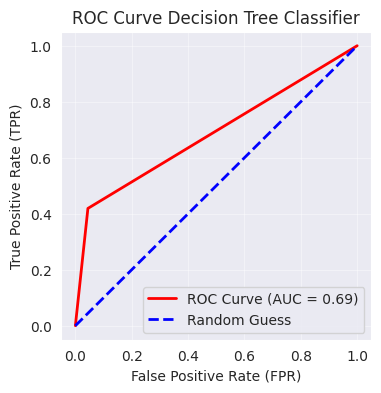

AUC/ROC: 0.69


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ambil nilai 'label' dan 'prediction' langsung
y_true = dt_preds.select('label').rdd.flatMap(lambda x: x).collect()
y_score = dt_preds.select('prediction').rdd.flatMap(lambda x: x).collect()

# Menghitung ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='red', lw=2, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Decision Tree Classifier')
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()

# Menampilkan AUC/ROC
print(f"AUC/ROC: {roc_auc:.2f}")

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


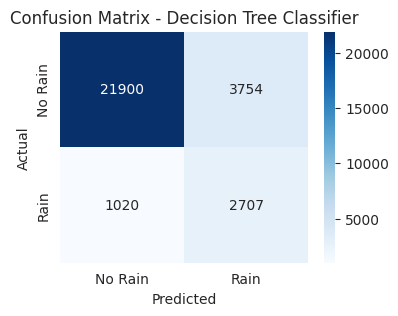

Accuracy: 0.8375
Precision: 0.41897539080637675
Recall: 0.7263214381540113
F1-score: 0.5314095013741658


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Ubah nama kolom 'RainTomorrow' menjadi 'label'
dt_preds = dt_preds.withColumnRenamed('RainTomorrow', 'label')

# Cast 'label' dan 'prediction' columns to double type
dt_preds = dt_preds.withColumn("label", col("label").cast("double"))
dt_preds = dt_preds.withColumn("prediction", col("prediction").cast("double"))

# Hitung confusion matrix
roc = dt_preds.select("label", "prediction")
metrics = MulticlassMetrics(roc.rdd)
conf_matrix = metrics.confusionMatrix().toArray()

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

# Accuracy, Precision, Recall, dan F1-Score
accuracy = metrics.accuracy
print(f"Accuracy: {accuracy:.4f}")
print("Precision:", metrics.precision(1.0))
print("Recall:", metrics.recall(1.0))
print("F1-score:", metrics.fMeasure(1.0))

## **Hyperparameter Tunning**

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml import Pipeline

# Define models
rf = RandomForestClassifier(labelCol="RainTomorrow", featuresCol="features", seed=42)
gbt = GBTClassifier(labelCol="RainTomorrow", featuresCol="features")
lr = LogisticRegression(labelCol="RainTomorrow", featuresCol="features")
dt = DecisionTreeClassifier(labelCol="RainTomorrow", featuresCol="features")

# Create param grids with reduced combinations
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10]) \
    .addGrid(gbt.maxDepth, [3]) \
    .build()

lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5]) \
    .build()

dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10]) \
    .addGrid(dt.maxBins, [32]) \
    .build()

# Cross-validator for Random Forest
rf_cv = CrossValidator(estimator=Pipeline(stages=[assembler, rf]),
                        estimatorParamMaps=rf_param_grid,
                        evaluator=evaluator,
                        numFolds=2)

# Cross-validator for Gradient-Boosted Trees
gbt_cv = CrossValidator(estimator=Pipeline(stages=[assembler, gbt]),
                        estimatorParamMaps=gbt_param_grid,
                        evaluator=evaluator,
                        numFolds=2)

# Cross-validator for Logistic Regression
lr_cv = CrossValidator(estimator=Pipeline(stages=[assembler, lr]),
                        estimatorParamMaps=lr_param_grid,
                        evaluator=evaluator,
                        numFolds=2)

# Cross-validator for Decision Tree
dt_cv = CrossValidator(estimator=Pipeline(stages=[assembler, dt]),
                        estimatorParamMaps=dt_param_grid,
                        evaluator=evaluator,
                        numFolds=2)

# Fit models with cross-validation
rf_cv_model = rf_cv.fit(trainingData)
gbt_cv_model = gbt_cv.fit(trainingData)
lr_cv_model = lr_cv.fit(trainingData)
dt_cv_model = dt_cv.fit(trainingData)

# Evaluate models
rf_cv_predictions = rf_cv_model.transform(testData)
gbt_cv_predictions = gbt_cv_model.transform(testData)
lr_cv_predictions = lr_cv_model.transform(testData)
dt_cv_predictions = dt_cv_model.transform(testData)

rf_cv_score = evaluator.evaluate(rf_cv_predictions)
gbt_cv_score = evaluator.evaluate(gbt_cv_predictions)
lr_cv_score = evaluator.evaluate(lr_cv_predictions)
dt_cv_score = evaluator.evaluate(dt_cv_predictions)

print(f"Random Forest CV Accuracy: {rf_cv_score}")
print(f"Gradient-Boosted Tree CV Accuracy: {gbt_cv_score}")
print(f"Logistic Regression CV Accuracy: {lr_cv_score}")
print(f"Decision Tree CV Accuracy: {dt_cv_score}")

Random Forest CV Accuracy: 0.8632441143032183
Gradient-Boosted Tree CV Accuracy: 0.8457855064336891
Logistic Regression CV Accuracy: 0.8695402783191296
Decision Tree CV Accuracy: 0.5856936895908947
